# Compare S&P 500 with a DAX

In [27]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas_datareader.data as web
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr

## Load SPX & DAX

In [28]:
spx = web.DataReader('^GSPC',  'yahoo', datetime(2008,1,1), datetime(2021,1,1))
dax = web.DataReader('^GDAXI',  'yahoo', datetime(2008,1,1), datetime(2021,1,1))

## Convert & merge

In [29]:
spx = spx[['Adj Close']]
dax = dax[['Adj Close']]
spx.columns = ['SPX']
dax.columns = ['DAX']
spx_dax_df = spx.join(dax, how='inner')

In [30]:
spx_dax_df = spx_dax_df.asfreq(pd.infer_freq(spx_dax_df.index))

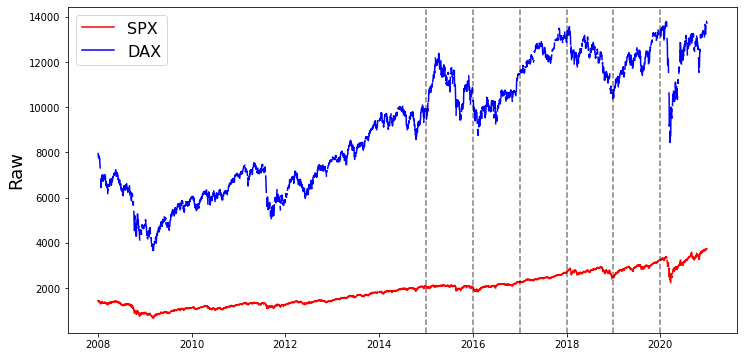

In [31]:
plt.figure(figsize=(12,6))
spx = plt.plot(spx_dax_df['SPX'], color='red')
dax = plt.plot(spx_dax_df['DAX'], color='blue')

for year in range(2015, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    plt.ylabel('Raw', fontsize=18)

plt.legend(['SPX', 'DAX'], fontsize=16)

## Normalize

In [32]:
avgs = spx_dax_df.mean()
devs = spx_dax_df.std()

In [33]:
for col in spx_dax_df.columns:
    spx_dax_df[col] = (spx_dax_df[col] - avgs.loc[col]) / devs.loc[col]

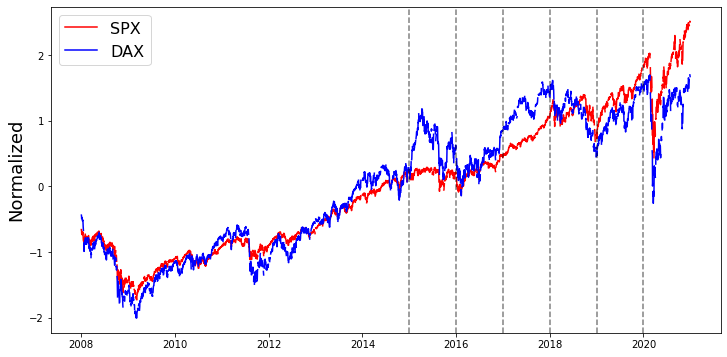

In [34]:
plt.figure(figsize=(12,6))
spx = plt.plot(spx_dax_df['SPX'], color='red')
dax = plt.plot(spx_dax_df['DAX'], color='blue')

for year in range(2015, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    plt.ylabel('Normalized', fontsize=18)

plt.legend(['SPX', 'DAX'], fontsize=16)

## Remove Trend

In [35]:
spx_dax_df = spx_dax_df.diff().dropna()

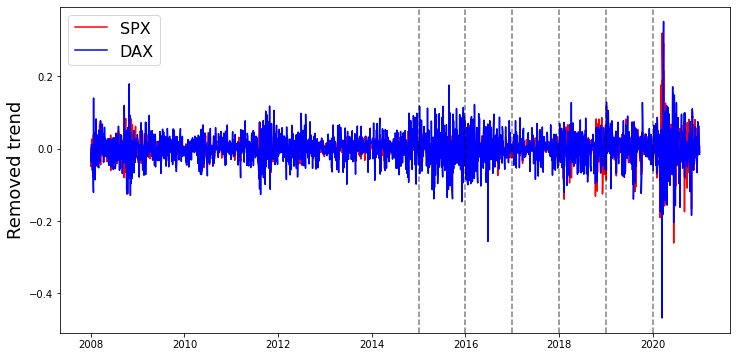

In [36]:
plt.figure(figsize=(12,6))
spx = plt.plot(spx_dax_df['SPX'], color='red')
dax = plt.plot(spx_dax_df['DAX'], color='blue')

for year in range(2015, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    plt.ylabel('Removed trend', fontsize=18)

plt.legend(['SPX', 'DAX'], fontsize=16)

## Remove increased vola

In [37]:
annual_volatility = spx_dax_df.groupby(spx_dax_df.index.year).std()
annual_volatility

,SPX,DAX
Date,,
2008,0.036207,0.043580
2009,0.018449,0.028959
2010,0.018124,0.025949
2011,0.024095,0.039162
2012,0.015655,0.029281
2013,0.015794,0.027506
2014,0.019682,0.036667
2015,0.026730,0.057624
2016,0.023698,0.047604


In [38]:
spx_dax_df['spx_annual_vol'] = spx_dax_df.index.map(lambda d: annual_volatility.loc[d.year, 'SPX'])
spx_dax_df['dax_annual_vol'] = spx_dax_df.index.map(lambda d: annual_volatility.loc[d.year, 'DAX'])
spx_dax_df

,SPX,DAX,spx_annual_vol,dax_annual_vol
Date,,,,
2008-01-03,0.000000,-0.014909,0.036207,0.043580
2008-01-04,-0.049291,-0.036529,0.036207,0.043580
2008-01-08,-0.036056,0.012023,0.036207,0.043580
2008-01-09,0.026276,-0.024646,0.036207,0.043580
2008-01-10,0.015538,-0.025503,0.036207,0.043580
...,...,...,...,...
2020-12-18,-0.018132,-0.013458,0.079089,0.078417
2020-12-22,-0.010627,0.062937,0.079089,0.078417
2020-12-23,0.003815,0.061951,0.079089,0.078417


In [39]:
spx_dax_df['SPX'] = spx_dax_df['SPX'] / spx_dax_df['spx_annual_vol']
spx_dax_df['DAX'] = spx_dax_df['DAX'] / spx_dax_df['dax_annual_vol']
spx_dax_df

,SPX,DAX,spx_annual_vol,dax_annual_vol
Date,,,,
2008-01-03,0.000000,-0.342102,0.036207,0.043580
2008-01-04,-1.361353,-0.838200,0.036207,0.043580
2008-01-08,-0.995826,0.275872,0.036207,0.043580
2008-01-09,0.725699,-0.565525,0.036207,0.043580
2008-01-10,0.429132,-0.585193,0.036207,0.043580
...,...,...,...,...
2020-12-18,-0.229263,-0.171628,0.079089,0.078417
2020-12-22,-0.134363,0.802592,0.079089,0.078417
2020-12-23,0.048238,0.790024,0.079089,0.078417


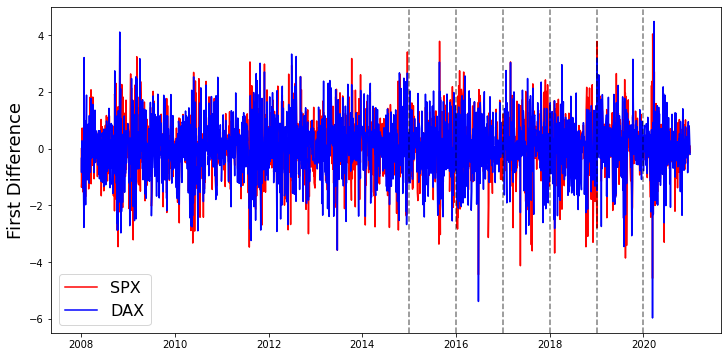

In [40]:
plt.figure(figsize=(12,6))
spx = plt.plot(spx_dax_df['SPX'], color='red')
dax = plt.plot(spx_dax_df['DAX'], color='blue')

for year in range(2015, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    plt.ylabel('First Difference', fontsize=18)

plt.legend(['SPX', 'DAX'], fontsize=16)

## Remove Seasonality

In [41]:
month_avgs = spx_dax_df.groupby(spx_dax_df.index.month).mean()
month_avgs

,SPX,DAX,spx_annual_vol,dax_annual_vol
Date,,,,
1,0.045645,-0.003589,0.028033,0.040612
2,0.104548,-0.019257,0.027750,0.040438
3,0.065329,0.095050,0.027496,0.040273
4,0.130385,0.100379,0.028032,0.040770
5,-0.090875,-0.059046,0.027533,0.040218
6,0.058042,-0.041978,0.027522,0.040395
7,0.136282,0.069510,0.028239,0.040966
8,-0.008080,-0.122699,0.027385,0.040071
9,0.066298,0.111520,0.027933,0.040748


In [42]:
spx_dax_df['spx_month_avg'] = spx_dax_df.index.map(lambda d: month_avgs.loc[d.month, 'SPX'])
spx_dax_df['dax_month_avg'] = spx_dax_df.index.map(lambda d: month_avgs.loc[d.month, 'DAX'])
spx_dax_df

,SPX,DAX,spx_annual_vol,dax_annual_vol,spx_month_avg,dax_month_avg
Date,,,,,,
2008-01-03,0.000000,-0.342102,0.036207,0.043580,0.045645,-0.003589
2008-01-04,-1.361353,-0.838200,0.036207,0.043580,0.045645,-0.003589
2008-01-08,-0.995826,0.275872,0.036207,0.043580,0.045645,-0.003589
2008-01-09,0.725699,-0.565525,0.036207,0.043580,0.045645,-0.003589
2008-01-10,0.429132,-0.585193,0.036207,0.043580,0.045645,-0.003589
...,...,...,...,...,...,...
2020-12-18,-0.229263,-0.171628,0.079089,0.078417,0.038525,0.046930
2020-12-22,-0.134363,0.802592,0.079089,0.078417,0.038525,0.046930
2020-12-23,0.048238,0.790024,0.079089,0.078417,0.038525,0.046930


In [43]:
spx_dax_df['SPX'] = spx_dax_df['SPX'] - spx_dax_df['spx_month_avg']
spx_dax_df['DAX'] = spx_dax_df['DAX'] - spx_dax_df['dax_month_avg']
spx_dax_df

,SPX,DAX,spx_annual_vol,dax_annual_vol,spx_month_avg,dax_month_avg
Date,,,,,,
2008-01-03,-0.045645,-0.338513,0.036207,0.043580,0.045645,-0.003589
2008-01-04,-1.406999,-0.834611,0.036207,0.043580,0.045645,-0.003589
2008-01-08,-1.041471,0.279461,0.036207,0.043580,0.045645,-0.003589
2008-01-09,0.680054,-0.561936,0.036207,0.043580,0.045645,-0.003589
2008-01-10,0.383487,-0.581604,0.036207,0.043580,0.045645,-0.003589
...,...,...,...,...,...,...
2020-12-18,-0.267787,-0.218557,0.079089,0.078417,0.038525,0.046930
2020-12-22,-0.172887,0.755662,0.079089,0.078417,0.038525,0.046930
2020-12-23,0.009713,0.743094,0.079089,0.078417,0.038525,0.046930


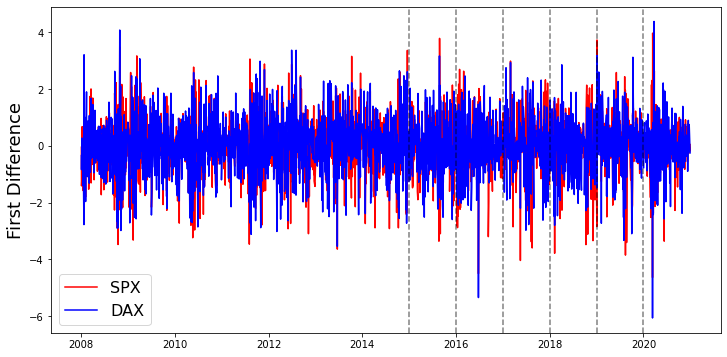

In [44]:
plt.figure(figsize=(12,6))
spx = plt.plot(spx_dax_df['SPX'], color='red')
dax = plt.plot(spx_dax_df['DAX'], color='blue')

for year in range(2015, 2021):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    plt.ylabel('First Difference', fontsize=18)

plt.legend(['SPX', 'DAX'], fontsize=16)

## PACF DAX

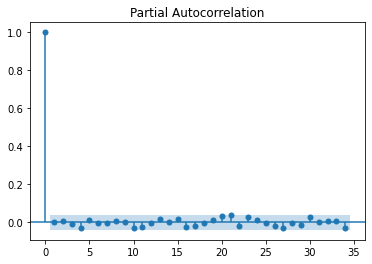

In [45]:
plot_pacf(spx_dax_df['DAX'])
plt.show()

## Correlation between "DAX" and lagged "SPX"

In [46]:
for lag in range(1, 14):
    dax_series = spx_dax_df['DAX'].iloc[lag:]
    lagged_spx_series = spx_dax_df['SPX'].iloc[:-lag]
    print('Lag: %s'%lag)
    print(pearsonr(dax_series, lagged_spx_series))
    print('------')

Lag: 1
(0.109592247372611, 4.0922771462679854e-08)
------
Lag: 2
(-0.01688371995465677, 0.3994294862762343)
------
Lag: 3
(-0.012162725150141185, 0.5439303661877184)
------
Lag: 4
(-0.024366922058763174, 0.22409115147951747)
------
Lag: 5
(-0.016016092260573253, 0.4243766195817126)
------
Lag: 6
(0.03254512039019267, 0.10452817735869371)
------
Lag: 7
(-0.0033529412099840283, 0.8672436466135606)
------
Lag: 8
(0.035508769470889545, 0.07664648293200607)
------
Lag: 9
(-0.007819895065074897, 0.6967522608816029)
------
Lag: 10
(-0.03276873042536855, 0.1024415529005395)
------
Lag: 11
(-0.01959505048587538, 0.3289582086677749)
------
Lag: 12
(-0.015098138762575286, 0.45205111607497234)
------
Lag: 13
(0.009305431230783803, 0.643099137138348)
------


## Fit a VAR Model

In [47]:
spx_dax_df = spx_dax_df[['SPX', 'DAX']]

model = VAR(spx_dax_df)

model_fit = model.fit(maxlags=13)
model_fit.summary()

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 26, Apr, 2021
Time:                     14:08:54
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.377750
Nobs:                     2482.00    HQIC:                 -0.458342
Log likelihood:          -6363.77    FPE:                   0.603927
AIC:                    -0.504304    Det(Omega_mle):        0.590999
--------------------------------------------------------------------
Results for equation SPX
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.002249         0.019986            0.113           0.910
L1.SPX         -0.060177         0.025805           -2.332           0.020
L1.DAX          0.010933         0.026020            0.420           0.674
L2.SPX     